# Assignment

**Target**:

You are making 3 versions of your 5th assignment's best model (or pick one from best assignments):
- Network with Group Normalization
- Network with Layer Normalization
- Network with L1 + BN


**Benefits of Normalization**

![im](https://i.ibb.co/0p0r6VW/Capture.png)


# Solution

## Function for Misclassified Image

In [99]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [100]:
def display_errors(model,
                   val_loader,
                   misclassified_image_row = 2,
                   misclassified_image_col = 5):
    """ This function shows 10 images with their predicted and real labels"""
    incorrect_examples = []
    model.eval()
    with torch.no_grad():
      for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, pred = torch.max(output,1)
        # correct += pred.eq(target.view_as(pred)).sum().item()
        idxs_mask = ((pred == target) == False).nonzero()
        # idxs_mask = (pred - target != 0)
        match = idxs_mask.cpu().numpy()
        
        
        if (idxs_mask.shape[0] > 0 ):
          mydata = list(match.reshape(-1))
          for i in range(len(mydata)-1):
            incorrect_examples.append(data[i].cpu())
            # if (len(incorrect_examples) > 20):
            #   break
            
            # print(f"mydata:{mydata[i]}")
          # print(f"idxs_mask:{idxs_mask}")
          # print(type(match))
          # print(f"idxs_mask reshaped:{type(match.reshape(-1))})")
          # print(f"idxs_mask list:{list(match.reshape(-1))}")
          # print(f"match:{match[0]}, length:{len(match)}")
          # incorrect_examples.append(data[mydata].cpu())
        # if (len(incorrect_examples) > 20):
        #   break ## this is done to ensure we dont store too many images and to save memory
    
    print(f"Number of misclassified Image:{len(incorrect_examples)}")
    n = 0
    nrows = misclassified_image_row
    ncols = misclassified_image_col
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)

    for row in range(nrows):
      for col in range(ncols):
        # print(incorrect_examples[n])
        img = incorrect_examples[n]
        # print(img)
        img = img/2 + 0.5
        img = np.clip(img, 0, 1)
        ax[row,col].imshow(img.reshape(28,28))
        # print('\n')
        n += 1
    

In [101]:
# display_errors(model,test_loader)

## Network with Group Normalization

### What is Group Normalization?

GN takes away the dependance on batch size for normalization and in doing so mitigates the problem suffered by BN. Let’s look at how GN compares to BN for training accross various batch sizes keeping all else same. ![im](https://amaarora.github.io/images/BN_batch_size.png)

Let’s consider that we have a batch of dimension (N, C, H, W) that needs to be normalized.

Here,

N: Batch Size
C: Number of Channels
H: Height of the feature map
W: Width of the feature map
![im](https://amaarora.github.io/images/GN_BN_LN_IN.png)

Finally, for group norm, the batch is first divided into groups (32 by default, discussed later). The batch with dimension (N, C, W, H) is first reshaped to (N, G, C//G, H, W) dimensions where G represents the number of groups. Finally, the mean and std deviation are calculated along the groups, that is (H, W) and along C//G channels. This is also illustrated very well in fig-4.

One key thing to note here, if C == G, that is the number of groups are set to be equal to the number of channels (one channel per group), then GN becomes IN.

And if, G == 1, that is number of groups is set to 1, GN becomes LN.
![im](https://amaarora.github.io/images/gn_explained.jpg)

### GroupNorm Network and Performance

In [102]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [103]:
class GroupNormNet(nn.Module):
    def __init__(self):
        super(GroupNormNet, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            # nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.GroupNorm(2, 8)

        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.GroupNorm(2, 10)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            # nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.GroupNorm(4, 20)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.GroupNorm(2, 10)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.GroupNorm(2, 10),
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            # nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.GroupNorm(4, 20),
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(12),
            nn.GroupNorm(4, 12),
            nn.ReLU()
        ) # output_size = 7
        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            # nn.BatchNorm2d(15),
            nn.GroupNorm(3, 15),
            nn.ReLU()
        ) # output_size = 5
        self.dropout = nn.Dropout(0.07)
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)
        x = self.convblock2(x)
        # x = self.dropout(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        # x = self.dropout(x)
        x = self.convblock5(x)
        x = self.dropout(x)
        x = self.convblock6(x)
        # x = self.dropout(x)
        x = self.convblock7(x)
        x = self.pool1(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [104]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        
        # nn.init.zeros_(m.bias)

In [105]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = GroupNormNet().to(device)
# model.apply(weight_init)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
         GroupNorm-7           [-1, 10, 24, 24]              20
            Conv2d-8           [-1, 20, 22, 22]           1,800
              ReLU-9           [-1, 20, 22, 22]               0
        GroupNorm-10           [-1, 20, 22, 22]              40
          Dropout-11           [-1, 20, 22, 22]               0
        MaxPool2d-12           [-1, 20, 11, 11]               0
           Conv2d-13           [-1, 10, 11, 11]             200
             ReLU-14           [-1, 10,

In [106]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.RandomHorizontalFlip(p=0.2),
                        # transforms.ColorJitter(brightness=0.01, contrast=0.01),
                        transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [107]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    processed = 1
    model.train()
    pbar = tqdm(train_loader)

    for batch_idx, (data, target) in enumerate(pbar):
        # print(len(data))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_losses.append(loss)
        optimizer.step()
        scheduler.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print(correct)
        processed += len(data)
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [108]:
model = GroupNormNet().to(device)

In [109]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
#                                               base_lr=0.01,
#                                               max_lr=0.1)

from torch.optim.lr_scheduler import StepLR, MultiStepLR
scheduler = StepLR(optimizer, step_size=4500, gamma=0.1)
# scheduler = MultiStepLR(optimizer, milestones=[10,12,14], gamma=0.1)

In [110]:
for epoch in range(1, 15):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.09605670720338821 batch_id=468 Accuracy=89.54: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s]



Test set: Average loss: 0.0854, Accuracy: 9750/10000 (97.5000%)



loss=0.022158225998282433 batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:27<00:00, 16.87it/s]



Test set: Average loss: 0.0593, Accuracy: 9826/10000 (98.2600%)



loss=0.02948947809636593 batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:27<00:00, 16.88it/s]



Test set: Average loss: 0.0499, Accuracy: 9846/10000 (98.4600%)



loss=0.009798918850719929 batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:27<00:00, 16.84it/s]



Test set: Average loss: 0.0444, Accuracy: 9856/10000 (98.5600%)



loss=0.00971316359937191 batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:27<00:00, 17.01it/s]



Test set: Average loss: 0.0413, Accuracy: 9879/10000 (98.7900%)



loss=0.05467833951115608 batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:28<00:00, 16.71it/s]



Test set: Average loss: 0.0343, Accuracy: 9886/10000 (98.8600%)



loss=0.009098737500607967 batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:28<00:00, 16.68it/s]



Test set: Average loss: 0.0347, Accuracy: 9896/10000 (98.9600%)



loss=0.008118023164570332 batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:27<00:00, 16.98it/s]



Test set: Average loss: 0.0370, Accuracy: 9882/10000 (98.8200%)



loss=0.0038330331444740295 batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]



Test set: Average loss: 0.0339, Accuracy: 9902/10000 (99.0200%)



loss=0.001985121052712202 batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:27<00:00, 17.07it/s]



Test set: Average loss: 0.0292, Accuracy: 9914/10000 (99.1400%)



loss=0.007966526784002781 batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s]



Test set: Average loss: 0.0286, Accuracy: 9918/10000 (99.1800%)



loss=0.005035224370658398 batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]



Test set: Average loss: 0.0270, Accuracy: 9917/10000 (99.1700%)



loss=0.03719397634267807 batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:27<00:00, 17.03it/s]



Test set: Average loss: 0.0272, Accuracy: 9917/10000 (99.1700%)



loss=0.01501393597573042 batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:27<00:00, 16.94it/s]



Test set: Average loss: 0.0269, Accuracy: 9921/10000 (99.2100%)



In [111]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

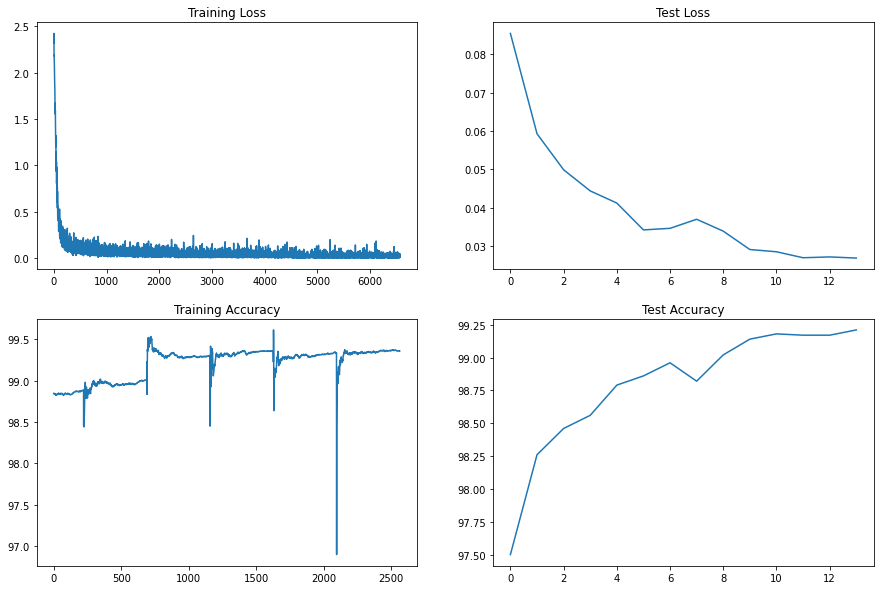

In [112]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Number of misclassified Image:28


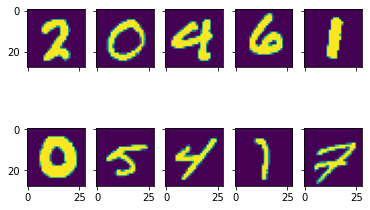

In [113]:
display_errors(model,test_loader)

## Network with Layer Normalization

### What is Layer Normalization?

To understand layer normalization, recall that a mini-batch consists of multiple examples with the same number of features. Mini-batches are matrices - or tensors if each input is multi-dimensional - where one axis corresponds to the batch and the other axis - or axes - correspond to the feature dimensions.
Batch normalization normalizes the input features across the batch dimension. The key feature of layer normalization is that it normalizes the inputs across the features.

![im](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F4374082%2F38fb84accef269b0bce2e75996e6d8e0%2Fz.png?generation=1599644663003667&alt=media)

In the layer norm, we take the average and variance from all of the features of a single sentence. Let’s see what it means using the same two sentences:

![im](https://i.ibb.co/BfgTjGQ/Picture1.png)

### LayerNorm Network and Performance

In [114]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [156]:
class LayerNormNet(nn.Module):
    def __init__(self):
        super(LayerNormNet, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm(torch.tensor([8, 26,26])),
            nn.ReLU()           

        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm(torch.tensor([10, 24, 24])),
            nn.ReLU()
            # nn.GroupNorm(2, 10)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm(torch.tensor([20, 22, 22])),
            nn.ReLU()
            # nn.GroupNorm(4, 20)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.LayerNorm(torch.tensor([10, 11, 11])),
            nn.ReLU()
            # nn.GroupNorm(2, 10)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm(torch.tensor([10, 9, 9])),
            nn.ReLU()
            # nn.GroupNorm(2, 10)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm(torch.tensor([20, 7, 7])),
            nn.ReLU()
            # nn.GroupNorm(4, 20)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.LayerNorm(torch.tensor([12, 7, 7])),
            nn.ReLU()
        ) # output_size = 7
        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.LayerNorm(torch.tensor([15, 1, 1])),
            nn.ReLU()
        ) # output_size = 5
        self.dropout = nn.Dropout(0.07)
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        # normalized_shape = torch.tensor(x.size()).index_select(0, indices)
        # x = nn.LayerNorm(x.size()[1:])
        x = self.dropout(x)

        x = self.convblock2(x)
        # x = self.dropout(x)

        x = self.convblock3(x)
        x = self.dropout(x)

        x = self.pool1(x)

        x = self.convblock4(x)
        # x = self.dropout(x)

        x = self.convblock5(x)
        x = self.dropout(x)

        x = self.convblock6(x)
        # x = self.dropout(x)

        x = self.convblock7(x)

        x = self.pool1(x)

        x = self.convblock8(x)

        x = self.gap(x)

        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [116]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        
        # nn.init.zeros_(m.bias)

In [157]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = LayerNormNet().to(device)
# model.apply(weight_init)

model

LayerNormNet(
  (convblock1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LayerNorm((tensor(8), tensor(26), tensor(26)), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LayerNorm((tensor(10), tensor(24), tensor(24)), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (convblock3): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LayerNorm((tensor(20), tensor(22), tensor(22)), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(20, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): LayerNorm((tensor(10), tensor(11), tensor(11)), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (convblock5): Sequential(
    (0): Conv2d(10, 10, kern

In [153]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.RandomHorizontalFlip(p=0.2),
                        # transforms.ColorJitter(brightness=0.01, contrast=0.01),
                        transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [143]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    processed = 1
    model.train()
    pbar = tqdm(train_loader)

    for batch_idx, (data, target) in enumerate(pbar):
        # print(len(data))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_losses.append(loss)
        optimizer.step()
        scheduler.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print(correct)
        processed += len(data)
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [122]:
# model = Net().to(device)

In [158]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
#                                               base_lr=0.01,
#                                               max_lr=0.1)

from torch.optim.lr_scheduler import StepLR, MultiStepLR
scheduler = StepLR(optimizer, step_size=4500, gamma=0.1)
# scheduler = MultiStepLR(optimizer, milestones=[10,12,14], gamma=0.1)

In [159]:
for epoch in range(1, 15):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.10950135439634323 batch_id=468 Accuracy=89.43: 100%|██████████| 469/469 [00:26<00:00, 17.40it/s]



Test set: Average loss: 0.1104, Accuracy: 9680/10000 (96.8000%)



loss=0.12666599452495575 batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]



Test set: Average loss: 0.0686, Accuracy: 9787/10000 (97.8700%)



loss=0.23204433917999268 batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:26<00:00, 17.56it/s]



Test set: Average loss: 0.0549, Accuracy: 9835/10000 (98.3500%)



loss=0.015910595655441284 batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]



Test set: Average loss: 0.0461, Accuracy: 9857/10000 (98.5700%)



loss=0.05970229580998421 batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:27<00:00, 17.35it/s]



Test set: Average loss: 0.0395, Accuracy: 9875/10000 (98.7500%)



loss=0.0926366075873375 batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:26<00:00, 17.61it/s]



Test set: Average loss: 0.0435, Accuracy: 9858/10000 (98.5800%)



loss=0.0461777001619339 batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]



Test set: Average loss: 0.0351, Accuracy: 9892/10000 (98.9200%)



loss=0.039033301174640656 batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:26<00:00, 17.60it/s]



Test set: Average loss: 0.0368, Accuracy: 9886/10000 (98.8600%)



loss=0.010392270050942898 batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:26<00:00, 17.47it/s]



Test set: Average loss: 0.0335, Accuracy: 9896/10000 (98.9600%)



loss=0.038157105445861816 batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:26<00:00, 17.44it/s]



Test set: Average loss: 0.0280, Accuracy: 9919/10000 (99.1900%)



loss=0.016893481835722923 batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]



Test set: Average loss: 0.0269, Accuracy: 9917/10000 (99.1700%)



loss=0.005991610232740641 batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:27<00:00, 17.36it/s]



Test set: Average loss: 0.0269, Accuracy: 9915/10000 (99.1500%)



loss=0.005208579357713461 batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0264, Accuracy: 9917/10000 (99.1700%)



loss=0.05329231917858124 batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s]



Test set: Average loss: 0.0262, Accuracy: 9913/10000 (99.1300%)



In [160]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

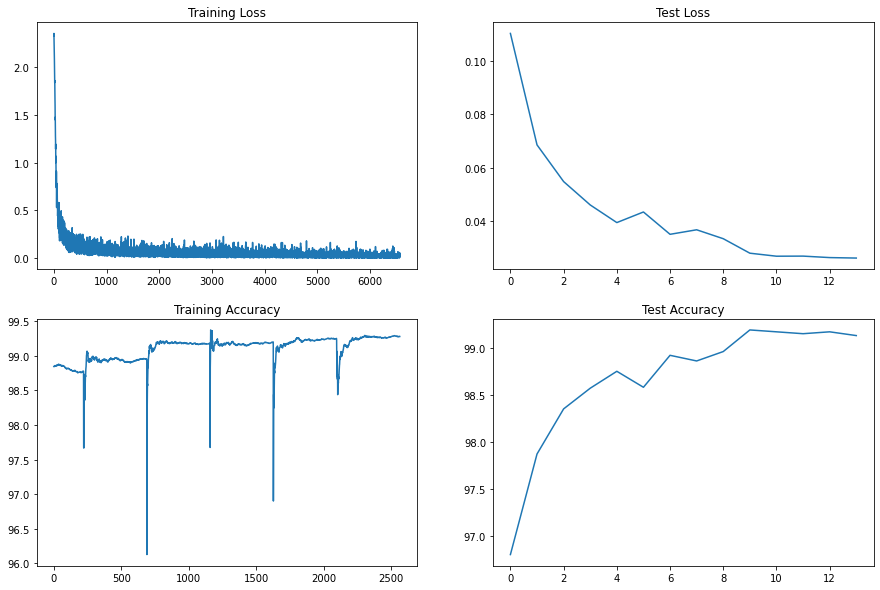

In [161]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Number of misclassified Image:34


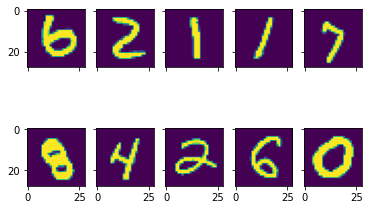

In [162]:
display_errors(model,test_loader)

## Network with L1 + BN

### What is Layer Normalization?

In [125]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [126]:
class BNNorml1Net(nn.Module):
    def __init__(self):
        super(BNNorml1Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            

        ) # output_size = 26


        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            # nn.GroupNorm(2, 10)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            # nn.GroupNorm(4, 20)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            # nn.GroupNorm(2, 10)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            # nn.GroupNorm(2, 10)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            # nn.GroupNorm(4, 20)
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 7
        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU()
        ) # output_size = 5
        self.dropout = nn.Dropout(0.07)
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.dropout(x)

        x = self.convblock2(x)
        x = self.dropout(x)

        x = self.convblock3(x)
        x = self.dropout(x)

        x = self.pool1(x)

        x = self.convblock4(x)
        x = self.dropout(x)

        x = self.convblock5(x)
        x = self.dropout(x)

        x = self.convblock6(x)
        x = self.dropout(x)

        x = self.convblock7(x)

        x = self.pool1(x)

        x = self.convblock8(x)

        x = self.gap(x)

        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [127]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        # nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
        
        # nn.init.zeros_(m.bias)

In [128]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = BNNorml1Net().to(device)
# model.apply(weight_init)

summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
             ReLU-11           [-1, 20, 22, 22]               0
          Dropout-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1, 10,

There is no analogous argument for L1, however this is straightforward to implement manually:



In [129]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.RandomHorizontalFlip(p=0.2),
                        # transforms.ColorJitter(brightness=0.01, contrast=0.01),
                        transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [130]:
def l1_penalty(params, l1_lambda=0.001):
  # This is taken from https://stackoverflow.com/questions/44641976/pytorch-how-to-add-l1-regularizer-to-activations
    """Returns the L1 penalty of the params."""
    l1_norm = sum(p.abs().sum() for p in params)
    return l1_lambda*l1_norm

# loss = loss_fn(outputs, labels) + l1_penalty(my_layer.parameters())

In [133]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    correct = 0
    processed = 1
    model.train()
    pbar = tqdm(train_loader)
    ## l1 regularization https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
    # l1_lambda = 0.001
    # l1_norm = sum(p.abs().sum() for p in model.parameters())
    
    for batch_idx, (data, target) in enumerate(pbar):
        # print(len(data))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        loss = loss + l1_penalty(model.parameters())
        loss.backward()
        train_losses.append(loss)
        optimizer.step()
        scheduler.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        # print(correct)
        processed += len(data)
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [134]:
# model = Net().to(device)

In [135]:
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
#                                               base_lr=0.01,
#                                               max_lr=0.1)

from torch.optim.lr_scheduler import StepLR, MultiStepLR
scheduler = StepLR(optimizer, step_size=4500, gamma=0.1)
# scheduler = MultiStepLR(optimizer, milestones=[10,12,14], gamma=0.1)

In [136]:
for epoch in range(1, 15):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

loss=0.5134201049804688 batch_id=468 Accuracy=91.32: 100%|██████████| 469/469 [00:28<00:00, 16.31it/s]



Test set: Average loss: 0.1114, Accuracy: 9695/10000 (96.9500%)



loss=0.4319475591182709 batch_id=468 Accuracy=96.57: 100%|██████████| 469/469 [00:29<00:00, 16.03it/s]



Test set: Average loss: 0.1908, Accuracy: 9399/10000 (93.9900%)



loss=0.4139091670513153 batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:28<00:00, 16.24it/s]



Test set: Average loss: 0.0862, Accuracy: 9754/10000 (97.5400%)



loss=0.32580140233039856 batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]



Test set: Average loss: 0.0772, Accuracy: 9772/10000 (97.7200%)



loss=0.3968324065208435 batch_id=468 Accuracy=97.01: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]



Test set: Average loss: 0.0843, Accuracy: 9735/10000 (97.3500%)



loss=0.4228363633155823 batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:29<00:00, 16.17it/s]



Test set: Average loss: 0.1408, Accuracy: 9558/10000 (95.5800%)



loss=0.3680722117424011 batch_id=468 Accuracy=97.02: 100%|██████████| 469/469 [00:29<00:00, 16.10it/s]



Test set: Average loss: 0.0881, Accuracy: 9755/10000 (97.5500%)



loss=0.44757556915283203 batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:29<00:00, 16.06it/s]



Test set: Average loss: 0.0891, Accuracy: 9742/10000 (97.4200%)



loss=0.3679051399230957 batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:29<00:00, 16.01it/s]



Test set: Average loss: 0.0830, Accuracy: 9757/10000 (97.5700%)



loss=0.2642269730567932 batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]



Test set: Average loss: 0.0422, Accuracy: 9885/10000 (98.8500%)



loss=0.22317172586917877 batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:28<00:00, 16.23it/s]



Test set: Average loss: 0.0370, Accuracy: 9898/10000 (98.9800%)



loss=0.2241540551185608 batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:29<00:00, 16.09it/s]



Test set: Average loss: 0.0357, Accuracy: 9894/10000 (98.9400%)



loss=0.17798301577568054 batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:29<00:00, 16.13it/s]



Test set: Average loss: 0.0457, Accuracy: 9874/10000 (98.7400%)



loss=0.25676387548446655 batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:29<00:00, 15.98it/s]



Test set: Average loss: 0.0392, Accuracy: 9892/10000 (98.9200%)



In [137]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Accuracy')

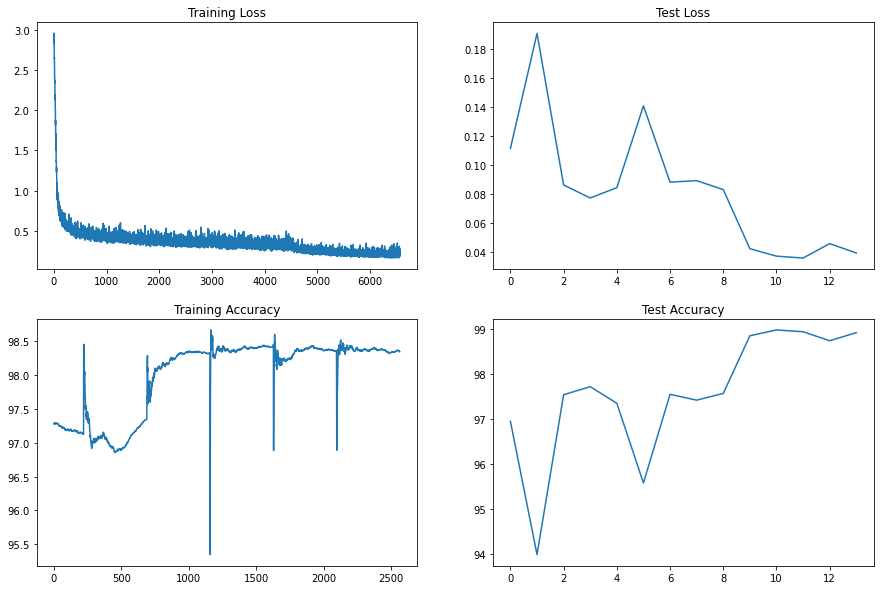

In [138]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Number of misclassified Image:49


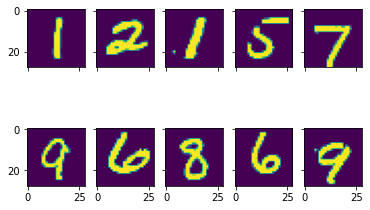

In [139]:
display_errors(model,test_loader)